## This notebook illustrates how to generate synthetic Spectro-Temporal Cascade Datasets and how to analyse them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cascapy.gammapy import *
from cascapy.constants import TeV

### Define path to the table model

In [2]:
#table = './table.h5'

# 1- Play with one single dataset

### Create one dataset

In [6]:
# Set a dataset ID
dsname = 'DS00000'
name = dsname+'/'+dsname

# Define model
model = CascadeTemporalSpectralModel(filename=table,frozen={'lambdaB':6},mname=dsname)
model.params["gamma"].value = 2.22
model.params["emax"].value = 30*TeV
model.params["alpha"].value = 1.6
model.params["logB"].value = -17.5

# Set observation properties
ne, emin, emax = 23, 0.105*TeV, 30*TeV
eb = np.logspace(np.log10(emin),np.log10(emax),ne)
zenith = 60
loc = 'north'

# Instantiate an empty dataset
DS = CascadeDatasets()
DS.create(model, eb=eb, loc=loc, zenith=zenith, name=dsname)

# fake one real observation with given random seed (random_seed=None would use a runtime dependent seed)
nobs = 1
DSf = DS.fake(nobs,random_state=42)[0]

# Save the dataset using the write() method of the gammapy, parent class
DSf.write(name,overwrite=True)

### Read one dataset
Note that no model is associate to the dataset at this stage, so that there is no predicted excess count

In [7]:
dsname = 'DS00000'
name = dsname+'/'+dsname
DS = CascadeDatasets().read(name,checksum=False)
print(DS[0])

SpectrumDatasetOnOff
--------------------

  Name                            : DS00000_00 

  Total counts                    : 9440 
  Total background counts         : 13.40
  Total excess counts             : 9426.60

  Predicted counts                : 1584.50
  Predicted background counts     : 1584.50
  Predicted excess counts         : nan

  Exposure min                    : 2.85e+06 m2 s
  Exposure max                    : 3.60e+08 m2 s

  Number of total bins            : 22 
  Number of fit bins              : 22 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 33085.20

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 67 
  Acceptance                      : 22 
  Acceptance off                  : 110 



# 2- Scan a dataset accross grids of parameters
Scanning means freezing some parameters to fixed values on pre-defined grids, while fitting for other parameters. This result in arrays of fit statistics for all grids points. It can be used to investigate degeneracy between parameters, and also to help the convergence of more global fits where the scanned parameters are let free.
### Scan the dataset

Define grids of parameters to scan. Here two parameters are scanned: `logB` and `emax`. Note that the order in which the grids are defined is important:
- The parameter space is investigated by varying first the last parameters. When fitting the data at a new grid point, the best-fit values found at the previous grid point are used as initial values for the free parameters. This might affect the convergence of sparse grids.
- Once the entired scanned parameter space has been scanned, this first scan is *reduced* iteratively, each time letting free the last parameter and refitting on grids points for the first parameters.  

In [13]:
# Read a stored dataset
dsname = 'DS00000'
name = dsname+'/'+dsname
DS = CascadeDatasets().read(name,checksum=False)

Create an instance of the `TableFit`class and hard-reeze parameter `lambdaB' 

In [14]:
fit = TableFit(table, DS, frozen={'lambdaB':6})

Optionally, limit the range of some parameters:

In [15]:
fit.parameters['emax'].min = 30*TeV

Define scan grids and run scan

In [16]:
# scan grids
scanE = np.linspace(1.1*TeV,70*TeV,3)
scanB = np.linspace(-20, -13, 3)
grids = {"logB":scanB, "emax":scanE}

# Perform 2d-scan, reduce to 1d- and 0d-scans and store all results to files 'name_xd.npy' where x=0,1,2 in this case
scan_2d, scan_1d, scan_0d = fit.run_scan(grids=grids,reduce=True, chatter=1, filename=name)

Performing 2-d scan
Performing 1-d scan
Performing 0-d scan


### Analyse scan results

Scan results (e.g. here `scan_0d`, `scan_1d`and `scan_2d`) can be used directly, or can be read from files as:

In [17]:
dsname = 'DS00000'
name = dsname+'/'+dsname
scan_0d = np.load(name+'_0d.npy', allow_pickle=True)[()]
scan_1d = np.load(name+'_1d.npy', allow_pickle=True)[()]
scan_2d = np.load(name+'_2d.npy', allow_pickle=True)[()]

Print best fit results

In [18]:
print(scan_0d)

nd = 0 
grids = {} 
success = True 
total_stat = 117.01484760483126 
 scale: 1.0939888002509446, gamma: 2.2080336072011635, alpha: 1.614399468887238, emax: 48.06561674158711, logB: -17.49537650261463, lambdaB: 6.0, 



Plot scan profile:

nd = 1 
grids = {'logB': array([-20. , -16.5, -13. ])} 
success = [ True  True  True] 
total_stat = [279.48209544 232.42009873 281.29412799] 
 scale: 0.19770494037252712, gamma: 2.109508775474082, alpha: 1.2923880856803514, emax: 96.12919607596378, logB: -20.0, lambdaB: 6.0, 
scale: 0.3537709941098578, gamma: 2.2394199868159737, alpha: 1.3777160782219706, emax: 48.065307065215414, logB: -16.5, lambdaB: 6.0, 
scale: 0.2667551414594688, gamma: 2.1622350682246796, alpha: 1.3023013339108072, emax: 112.15233068295704, logB: -13.0, lambdaB: 6.0, 



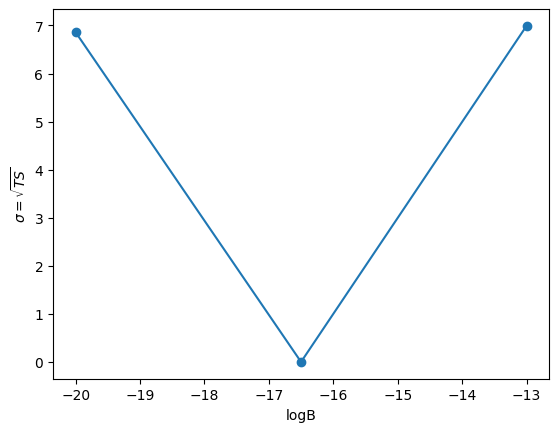

In [19]:
print(scan_1d)
ax = scan_1d.plot()

Plot scan map:

nd = 2 
grids = {'logB': array([-20. , -16.5, -13. ]), 'emax': array([ 56.95737934, 112.15236438])} 
success = ... 
total_stat = ... 
 params = ... 
 


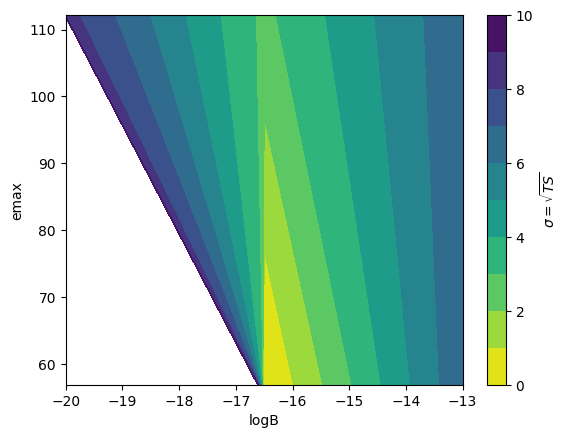

In [20]:
print(scan_2d)
ax = scan_2d.plot()

### Profile a 1-d scan
Once a basic 1-d scan is obtained, it can be used to further refine the regions around minima, and to get the parameter uncertainty at some levels.
The following cells allow to 
- Analyse the 1-d scan and get all regions of the initial parameter grids where **TS-TSmin < level**
- In each region, perform a global fit by letting free the scanned parameter, and get the TSmin of the entire parameter space 
- In each region, get the parameter values where **sqrt(TS-TSmin) < sigma** (with sigma=1,2,3,4,5 here)
- Add all found values (global fits results and uncertainty values) to the 1-d scan

Fitting region 0
success:    True
total stat: 117.01484760483126
Parameter(name='scale', value=0.3537709941098578, factor=0.3537709941098578, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=False, prior=None, id=0x432091ee0)
Parameter(name='gamma', value=2.2394199868159737, factor=2.2394199868159737, scale=1.0, unit=Unit(dimensionless), min=1.0, max=3.0, frozen=False, prior=None, id=0x432091bb0)
Parameter(name='alpha', value=1.3777160782219706, factor=1.3777160782219706, scale=1.0, unit=Unit(dimensionless), min=0.800000011920929, max=2.0, frozen=False, prior=None, id=0x432091f70)
Parameter(name='emax', value=48.065307065215414, factor=48.065307065215414, scale=1.0, unit=Unit(dimensionless), min=48.06529902, max=112.1523666381836, frozen=False, prior=None, id=0x432091b50)
Parameter(name='logB', value=-16.5, factor=-16.5, scale=1.0, unit=Unit(dimensionless), min=-21.0, max=-12.0, frozen=False, prior=None, id=0x432091d30)
Parameter(name='lambdaB', value=6.0, factor=6.0, scal

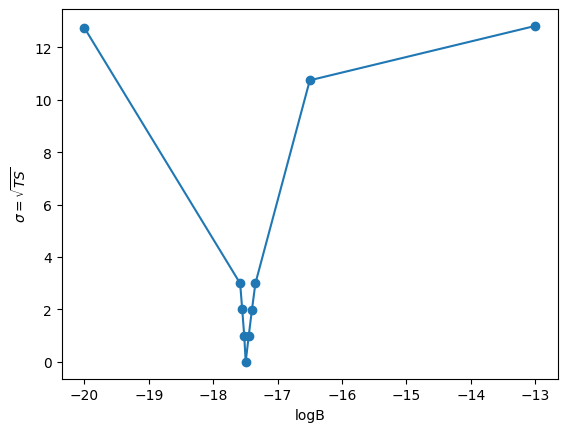

In [21]:
dsname = 'DS00000'
name = dsname+'/'+dsname

# load dataset to re-analyse
ds = CascadeDatasets().read(name,checksum=False)

# load existing 1-d scan
scan_1d = Scan().from_file(name+'_1d.npy')

# retrieve the table that was used to make the 1d-scan (could also be set manually)
#table = scan_1d.filename_table

# Setup TAble fit instance and freeze lambdaB for the following analysis
fit = TableFit(table, ds, frozen={'lambdaB':6})

# Profile and store results to file
fine_scan_1d = fit.profile_from_scan_1d(scan_1d,level=10, nsigma=[1,2,3], filename=dsname)

# Plot fine profile
ax = fine_scan_1d.plot()

# 3- Systematic analysis for many values of the magnetic field

### Create a series of datasets for many different values of parameter `logB`
The datasets are labeled from the B-values that were used to generate them

In [3]:
 # logB grid
gridB = np.linspace(-20.5,-12.5,8)

for logB in gridB:

    print(f"logB = {logB}")
    dsname = f"DS{-int(1000*logB)}"

    # Load table model and build dataset
    model = CascadeTemporalSpectralModel(filename=table,frozen={'lambdaB':6},mname=dsname)
    model.params["gamma"].value = 2.22
    model.params["emax"].value = 30*TeV
    model.params["alpha"].value = 1.6
    model.params["logB"].value = logB

    # Set observation properties
    ne, emin, emax = 23, 0.105*TeV, 30*TeV
    eb = np.logspace(np.log10(emin),np.log10(emax),ne)
    zenith = 60
    loc = 'north'

    # Instantiate an empty dataset
    DS = CascadeDatasets()
    DS.create(model, eb=eb, loc=loc, zenith=zenith, name=dsname)
    
    # fake one real observation per logB value
    nobs = 1
    DSf = DS.fake(nobs,random_state=42)[0]

    # Save dataset to file
    DSf.write(dsname+'/'+dsname,overwrite=True)

logB = -20.5
logB = -19.357142857142858
logB = -18.214285714285715
logB = -17.071428571428573
logB = -15.928571428571429
logB = -14.785714285714286
logB = -13.642857142857142
logB = -12.5


### Define a function to scan and profile one single dataset

In [4]:
def scan_one(iid,grids,table):

    print(f"Scanning dataset with logB = {-float(iid)/1000} \n")
    dsname = 'DS'+iid
    name = dsname+'/'+dsname
    
    # read dataset
    ds = CascadeDatasets().read(name,checksum=False)

    # Instantiate the TableFit class and hard-freeze lambdaB
    fit = TableFit(table, ds, frozen={'lambdaB':6})

    # perform scan
    scan_2d, scan_1d, scan_0d = fit.run_scan(grids=grids, chatter=0, filename=name, reduce=True)

    # perform profile
    scan_1d = fit.profile_from_scan_1d(scan_1d,level=10, nsigma=[1,2,3,4,5], filename=name,chatter=0)
    
    return scan_1d

### Get all datasets stored in the current directory
but dataset 00000 (only used for previous tests)

In [5]:
ids = get_dir_datasets(path='./')
if '00000' in ids:
    ids.remove('00000')

### Define scanning grids
Warning: logB must be the first parameter

In [6]:
gridB = np.linspace(-20.5,-12.5,10)
gridE = np.array([1.5,10,30,50])*TeV
grids = {'logB':gridB,'emax':gridE}

### Run parallel analysis

In [7]:
from itertools import repeat
from multiprocessing import Pool, set_start_method

set_start_method('fork', force=True)

nproc = 8

pool = Pool(processes=nproc)
pool.starmap(func=scan_one, iterable=zip(ids,repeat(grids),repeat(table)))
pool.close()
pool.join()

Scanning dataset with logB = -13.642 
Scanning dataset with logB = -12.5 
Scanning dataset with logB = -15.928 
Scanning dataset with logB = -14.785 
Scanning dataset with logB = -17.071 
Scanning dataset with logB = -18.214 
Scanning dataset with logB = -19.357 
Scanning dataset with logB = -20.5 










Value 112.1523666381836 is outside bounds [1.6021766662597656, 112.1523666381836] for parameter 'emax'


### Plot a logB-logB map
Warning: After fine profiling, the profiles of the different datasets have different grids. It is therefore not possible to directly use the usual `colormesh`, `surface` or other standart methods. An interpolaton step must be added.

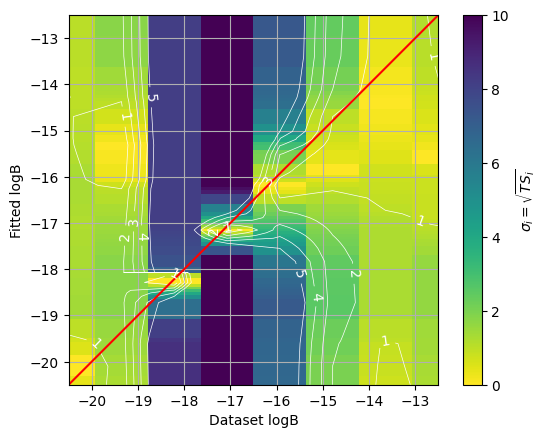

In [8]:
from scipy.interpolate import interp1d

vmax = 10

# get all datasets in current directory but dataset 00000 (only used for previous tests)
ids = get_dir_datasets(path='./')
if '00000' in ids:
    ids.remove('00000')
nx0 = len(ids)

# build a fine grids from the grids points of all datasets
X = []
X0 = []
for id in ids:
    prof = np.load(f'DS{id}/DS{id}_prof.npy', allow_pickle=True)[()]
    name = list(prof.grids.keys())[0]
    nval = len(prof.grids[name])
    X0 = np.append(X0,-float(id)/1000.)
    for x in prof.grids[name]:
        if x not in X:
            X = np.append(X, x)
X.sort()
nx = len(X)

# for each dataset, interpolate over this fine grid
Z = np.zeros((nx0,nx))
for i0,id in enumerate(ids):
    prof = np.load(f'DS{id}/DS{id}_prof.npy', allow_pickle=True)[()]
    name = list(prof.grids.keys())[0]
    xx = prof.grids[name]
    yy = np.sqrt( prof.total_stat - prof.total_stat.min() )
    f = interp1d(xx, yy, bounds_error=None, fill_value="extrapolate")
    Z[i0,:] = f(X)

# Plot a map made of vertical bands
cf = plt.pcolormesh(X0, X, Z.T, vmax=vmax, cmap='viridis_r')
cb = plt.colorbar(cf)

# Plot contours
levels = range(1,6)
cs = plt.contour(X0, X, Z.T, levels=levels,colors='w',linewidths=0.5)
plt.clabel(cs, cs.levels)

plt.plot((X0[-1],X0[0]),(X0[-1],X0[0]),color='r')
cb.ax.set_ylabel(r'$\sigma_i = \sqrt{TS_i}$')
plt.gca().set_aspect('equal')
plt.xlim(X0[-1],X0[0])
plt.ylim(X0[-1],X0[0])
plt.xlabel('Dataset '+name)
plt.ylabel('Fitted '+name)    
plt.grid()
plt.show()